<a href="https://colab.research.google.com/github/Parsa2820/50-years-lyrics/blob/master/notebooks/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Sharif University of Technology
Department of Computer Engineering

---
# Modern Information Retrieval Course
# **50 Years of the Best-Selling Music Artists Lyrics Comparison**
### Homework 2
### Dr. Asgari
### Parsa Mohammadian — 98102284
Spring 2022

---

## Introduction
The art of music play an important role in the human world. Besides the instrumental aspect, lyrics and content of a music are also important. In this project, I will explore and compare the lyrics of the best-selling music artists in a 50 years period (from 1969 to 2019). This list is taken from [Visual Capitalist](https://www.visualcapitalist.com/chart-toppers-50-years-of-the-best-selling-music-artists/) website. They have also visualized this data in an awesome [video](https://www.youtube.com/watch?v=a3w8I8boc_I). For the reference, I will use the image bellow to pick artist that has been top-selling for at least one consecutive year. Since the dataset is not provided, I have hardcoded the artists and their info in the code.

> Because of the dataset size limit of this project, I have only used some of the artists with introduced conditions. So I commented out the other artist in the code. The 4 remaining artist datasets size is 4.89 MB.

![top-seller-chart](../resources/top-sellers-chart.jpg)

---

In [13]:
class Artist:
    def __init__(self, name: str, top_seller_begin_year: int):
        self.name: str = name
        self.top_seller_begin_year: int = top_seller_begin_year
        self.lyrics: pd.DataFrame = None
        self.normalized_words_count: int = 0
        self.profanity_count: int = 0


artists = [
    Artist("The Beatles", 1969),
    # Artist("Elvis Presley", 1973),
    Artist("Elton John", 1975),
    # Artist("Eagles", 1977),
    Artist("Michael Jackson", 1980),
    # Artist("Madonna", 1985),
    Artist("Eminem", 2001),
    # Artist("Rihanna", 2008),
    # Artist("Drake", 2013)
]


## Required Libraries

---

In [14]:
"""
Run this cell to install required python packages.
Skip if you have already installed following packages.
"""
!pip install pandas
!pip install tqdm
!pip install nltk
!pip install better-profanity


In [15]:
import re
import string
import itertools
import functools
import pandas as pd
import tqdm
import nltk
import better_profanity as bp
import matplotlib.pyplot as plt


In [33]:
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\parsa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\parsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\parsa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\parsa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


True

## Dataset
The dataset consists of multiple csv files, each file named as "`<artist> Lyrics.csv`" and contains all songs of the artist with their lyrics. I have written the script in [dataset/lyrics-script](../datasets/lyrics-script/genius.py) to generate the dataset. In order to get lyrics, I used [Genius](https://genius.com/) API. It worths mentioning that the order of the songs in every file is according to the number of views of the song in Genius website.

---

In [17]:
"""
Load data
"""
DATA_FILE_PREFIX = "../datasets/"
DATA_FILE_SUFFIX = " Lyrics.csv"

for artist in tqdm.tqdm(artists):
    artist.lyrics = pd.read_csv(
        f"{DATA_FILE_PREFIX}{artist.name}{DATA_FILE_SUFFIX}")
    artist.lyrics.rename(columns={"Unnamed: 0": "idx"}, inplace=True)
    artist.lyrics.set_index("idx", inplace=True)
    artist.lyrics.dropna(inplace=True)

for artist in artists:
    print(f"\n{artist.name} with {artist.lyrics.size} songs",
          artist.lyrics.head(1), sep='\n')


100%|██████████| 4/4 [00:00<00:00, 18.23it/s]


The Beatles with 1660 songs
     song_name                                        song_lyrics
idx                                                              
0    Let It Be  Let It Be Lyrics[Verse 1]\nWhen I find myself ...

Elton John with 1204 songs
     song_name                                        song_lyrics
idx                                                              
0    Your Song  Your Song Lyrics[Verse 1]\nIt's a little bit f...

Michael Jackson with 1384 songs
       song_name                                        song_lyrics
idx                                                                
0    Billie Jean  Billie Jean Lyrics[Verse 1]\nShe was more like...

Eminem with 1016 songs
    song_name                                        song_lyrics
idx                                                             
0     Rap God  Rap God Lyrics[Intro]\n"Look, I was gonna go e...


## Tokenization

---

In [18]:
for artist in artists:
    artist.lyrics["song_lyrics_tokenized"] = artist.lyrics["song_lyrics"].apply(
        lambda x: nltk.word_tokenize(x))


## Normalization

---

In [52]:
def to_lower(tokens):
    """
    Converts the tokens to lower case.
    """
    return [token.lower() for token in tokens]


def remove_lyrics_tags(tokens):
    """
    Removes the tags added by Genius from the lyrics. 
    For example, [Chorus], [Verse 1], ...
    """
    new_tokens = []
    tag = False
    for i in range(len(tokens)):
        if tokens[i] == '[':
            tag = True
        elif tokens[i] == ']':
            tag = False
        elif not tag:
            new_tokens.append(tokens[i])
    return new_tokens


def remove_song_name(tokens):
    """
    Removes the song name from the tokens.
    """
    keyword = "lyrics"
    if keyword in tokens:
        return tokens[tokens.index(keyword) + 1:]
    return tokens[:]


def contains_any_of(token, chars):
    """
    Returns true if the token contains any of the characters in the given list.
    """
    return any(char in token for char in chars)


def remove_punctuation(tokens):
    """
    Removes punctuation from the given tokens.
    """
    return [token for token in tokens if not contains_any_of(token, string.punctuation+"’‘•")]


def remove_music_characters(tokens):
    """
    Removes ♪ characters from the given tokens.
    """
    return [token for token in tokens if not '♪' in token]


def remove_stop_words(tokens):
    """
    Removes stop words from the given tokens.
    """
    remove_stop_words.stop_words = set(nltk.corpus.stopwords.words('english'))
    with open("../resources/lyrics-stop-words", "r") as f:
        for line in f:
            remove_stop_words.stop_words.add(line.strip())

    return [token for token in tokens if token not in remove_stop_words.stop_words]


def normalize_lyrics(tokens):
    """
    Normalizes the tokens of the lyrics.
    """
    normalization_functions = [to_lower, remove_lyrics_tags, remove_music_characters,
                               remove_song_name, remove_punctuation, remove_stop_words]
    return functools.reduce(lambda x, f: f(x), normalization_functions, tokens)


In [53]:
for artist in artists:
    artist.lyrics["song_lyrics_normalized"] = artist.lyrics["song_lyrics_tokenized"].apply(
        normalize_lyrics)


## Profanity Analysis and Removal

---

In [27]:
# for artist in artists:
#     for l in tqdm.tqdm(artist.lyrics["song_lyrics_normalized"], desc=f"{artist.name} lyrics"):
#         for token in l:
#             if bp.profanity.contains_profanity(token):
#                 artist.profanity_count += 1
#             artist.normalized_words_count += 1

for artist in artists:
    def count(tokens):
        artist.normalized_words_count += len(tokens)
        for token in tokens:
            if bp.profanity.contains_profanity(token):
                artist.profanity_count += 1
    artist.lyrics["song_lyrics_normalized"].apply(count)


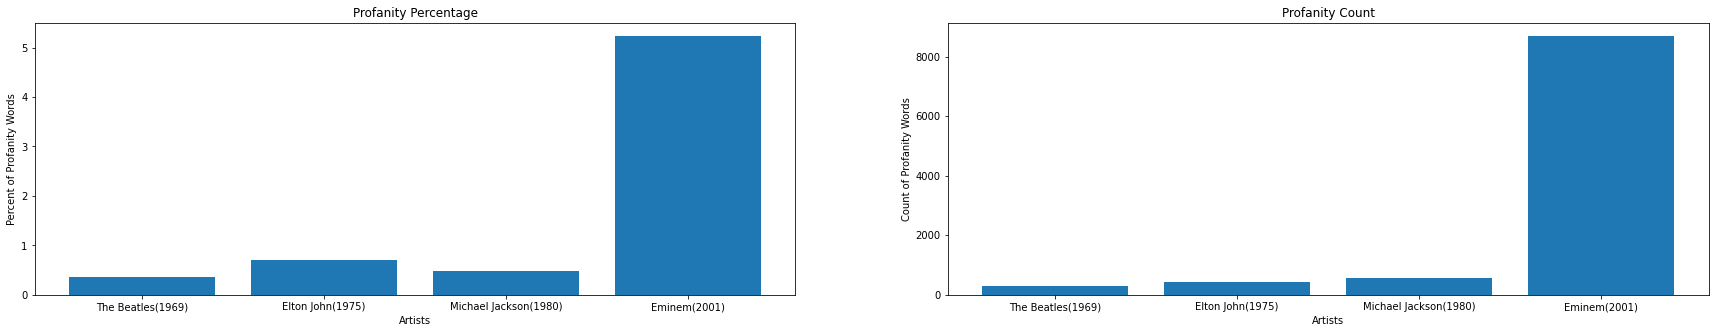

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(30, 5))
axs[0].set_title("Profanity Percentage")
axs[0].set_xlabel("Artists")
axs[0].set_ylabel("Percent of Profanity Words")
axs[0].bar(range(len(artists)), [artist.profanity_count /
           artist.normalized_words_count*100 for artist in artists])
axs[0].set_xticks(range(len(artists)))
axs[0].set_xticklabels(
    [f"{artist.name}({artist.top_seller_begin_year})" for artist in artists])
axs[1].set_title("Profanity Count")
axs[1].set_xlabel("Artists")
axs[1].set_ylabel("Count of Profanity Words")
axs[1].bar(range(len(artists)), [artist.profanity_count for artist in artists])
axs[1].set_xticks(range(len(artists)))
axs[1].set_xticklabels(
    [f"{artist.name}({artist.top_seller_begin_year})" for artist in artists])
plt.show()


## Stemming and Lemmatization

Here I have used Porter2 stemming algorithm to stem the words in the lyrics. The reason for preferring stemming over lemmatization is that it is more suitable for lyrics. We can see tons of examples in the lyrics which used ing form of the verb like "talkin" instead of "talking". In such a situation, the stemmer will remove suffix and leave the root word but lemmatization will not.

---

In [54]:
stemmer = nltk.stem.SnowballStemmer('english')

for artist in artists:
    artist.lyrics["song_lyrics_stemmed"] = (artist.lyrics["song_lyrics_normalized"]
                                                     .apply(lambda x: [stemmer.stem(t) for t in x]))


## Frequency Analysis and Find Stop Words

Although removing stop words was used in th normalization process, there are some extra worthless words in lyrics that we can determine by frequency analysis. So after the first frequency analysis, I gathered some other stop words in "`resources/lyrics-stop-words`" file and modified the normalization process to remove them.

> Keep in mind that tokens are stemmed, so it is possible to see misspelled words in the frequency analysis result.

---

In [55]:
for artist in artists:
    all_lyrics = itertools.chain(*artist.lyrics["song_lyrics_stemmed"])
    artist.freq_dist = nltk.FreqDist(all_lyrics)


In [59]:
freq_dist_dic = {}

for artist in artists:
    freq_dist = artist.freq_dist.most_common(20)
    freq_dist_profanity_filtered = []
    for word, count in freq_dist:
        freq_dist_profanity_filtered.append((bp.profanity.censor(word), count))
    freq_dist_dic[artist.name] = freq_dist_profanity_filtered

freq_dist_df = pd.DataFrame(freq_dist_dic)
freq_dist_df


,The Beatles,Elton John,Michael Jackson,Eminem
0,"(love, 1856)","(love, 960)","(love, 2928)","(like, 3070)"
1,"(know, 1587)","(like, 776)","(realli, 2380)","(get, 2242)"
2,"(get, 1119)","(know, 548)","(got, 1729)","(got, 1682)"
3,"(go, 1063)","(go, 547)","(babi, 1701)","(****, 1458)"
4,"(come, 954)","(time, 493)","(know, 1653)","(****, 1355)"
5,"(back, 888)","(never, 492)","(get, 1613)","(know, 1310)"
6,"(got, 877)","(got, 457)","(time, 1592)","(back, 1281)"
7,"(let, 851)","(get, 437)","(one, 1391)","(go, 1220)"
8,"(babi, 837)","(one, 404)","(bad, 1341)","(one, 1004)"
9,"(well, 709)","(see, 404)","(want, 1340)","(say, 900)"
